(The prevalence of malaria in the Gambia)=
# The prevalence of malaria in the Gambia

:::{post} Aug 24, 2024 
:tags: spatial, autoregressive, count data
:category: beginner, tutorial
:author: Jonathan Dekermanjian
:::

# Imports

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

:::{include} ../extra_installs.md
:::

In [2]:
# These dependencies need to be installed separately from PyMC
import folium
import geopandas as gpd
import mapclassify
import rasterio as rio

from pyproj import Transformer

# Introduction

Often, we find ourselves with a sample of continuous measurements that are spatially related (Geostatistical data) and our goal is to determine an estimate of that measure in unsampled surrounding areas. In the following case-study we look at the number of individuals who test positive for malaria in our sample of 65 villages across the Gambia region and proceed with estimating the prevalence (total positive / total individuals tested) of malaria within the surrounding areas to the 65 sampled villages. 

# Data Processing

In [3]:
# load the tabular data
try:
    gambia = pd.read_csv("../data/gambia_dataset.csv")
except FileNotFoundError:
    gambia = pd.read_csv(pm.get_data("gambia_dataset.csv"))
gambia.head()

,Unnamed: 0,x,y,pos,age,netuse,treated,green,phc
0,1850,349631.3,1458055,1,1783,0,0,40.85,1
1,1851,349631.3,1458055,0,404,1,0,40.85,1
2,1852,349631.3,1458055,0,452,1,0,40.85,1
3,1853,349631.3,1458055,1,566,1,0,40.85,1
4,1854,349631.3,1458055,0,598,1,0,40.85,1


The data are currently on the individual person level but for our purposes we need it to be on the village level. We will aggregate the data by village to compute the total number of people tested, the number of people who tested positive, and the sample prevalence; which will be computed by dividing the total tested positive by the total tested individuals.

In [4]:
# For each village compute the total tested, total positive, and the prevalence
gambia_agg = (
    gambia.groupby(["x", "y"])
    .agg(total=("x", "size"), positive=("pos", "sum"))
    .eval("prev = positive / total")
    .reset_index()
)
gambia_agg.head()

,x,y,total,positive,prev
0,349631.3,1458055,33,17,0.515152
1,358543.1,1460112,63,19,0.301587
2,360308.1,1460026,17,7,0.411765
3,363795.7,1496919,24,8,0.333333
4,366400.5,1460248,26,10,0.384615


We need to convert our dataframe into a geodataframe. In order to do this we need to know what coordinate reference system (CRS) either geographic coordinate system (GCS) or projected coordinate system (PCS) to use. GCS tells you where your data is on the earth, whereas PCS tells you how to draw your data on a two-dimensional plane. There are many different GCS/PCS because each GCS/PCS is a model of the earth's surface. However, the earth's surface is variable from one location to another. Therefore, different GCS/PCS versions will be more accurate depending on the geography your analysis is based in. Since our analysis is in the Gambia we will use PCS [EPSG 32628](https://epsg.io/32628) and GCS [EPSG 4326](https://epsg.io/4326) when plotting on a globe. Where EPSG stands for European Petroluem Survey Group, which is an organization that maintains geodetic parameters for coordinate systems.

In [5]:
# Create a GeoDataframe and set coordinate reference system to EPSG 4326
gambia_gpdf = gpd.GeoDataFrame(
    gambia_agg, geometry=gpd.points_from_xy(gambia_agg["x"], gambia_agg["y"]), crs="EPSG:32628"
).drop(["x", "y"], axis=1)

gambia_gpdf_4326 = gambia_gpdf.to_crs(crs="EPSG:4326")

In [6]:
# Get an interactive plot of the data with a cmap on the prevalence values
gambia_gpdf_4326.round(2).explore(column="prev")

We want to include on our map the elevations within the Gambia. To do that we extract the elevation values store in our raster file and overlay it on the map. Areas with darker red signify higher elevation.

/opt/miniconda3/envs/pymc_examples_contrib/lib/python3.12/site-packages/branca/utilities.py:320: RuntimeWarning: invalid value encountered in cast
  array = array.astype("uint8")



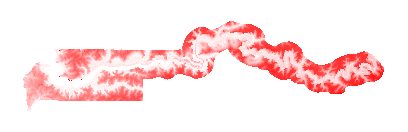

In [7]:
# Overlay the raster image of elevations in the Gambia on top of the map
m = gambia_gpdf_4326.round(2).explore(column="prev")

## Load the elevation rasterfile
in_path = "../data/GMB_elv_msk.tif"

dst_crs = "EPSG:4326"

with rio.open(in_path) as src:

    img = src.read()

    src_crs = src.crs["init"].upper()
    min_lon, min_lat, max_lon, max_lat = src.bounds
    xs = gambia_gpdf_4326["geometry"].x
    ys = gambia_gpdf_4326["geometry"].y
    rows, cols = rio.transform.rowcol(src.transform, xs, ys)

## Conversion of elevation locations from UTM to WGS84 CRS
bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]

bounds_fin = []

for item in bounds_orig:
    # converting to lat/lon
    lat = item[0]
    lon = item[1]

    proj = Transformer.from_crs(
        int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True
    )

    lon_n, lat_n = proj.transform(lon, lat)

    bounds_fin.append([lat_n, lon_n])

# Finding the center of latitude & longitude
centre_lon = bounds_fin[0][1] + (bounds_fin[1][1] - bounds_fin[0][1]) / 2
centre_lat = bounds_fin[0][0] + (bounds_fin[1][0] - bounds_fin[0][0]) / 2

# Overlay raster
m.add_child(
    folium.raster_layers.ImageOverlay(
        img.transpose(1, 2, 0),
        opacity=0.7,
        bounds=bounds_fin,
        overlay=True,
        control=True,
        cross_origin=False,
        zindex=1,
        colormap=lambda x: (1, 0, 0, x),
    )
)

m

We will want to include elevation as a covariate in our model. So, we need to extract the values from the raster image and store it into a dataframe.

In [8]:
# Pull the elevation values from the raster file and put them into a dataframe
path = "../data/GMB_elv_msk.tif"

with rio.open(path) as f:
    arr = f.read(1)
    mask = arr != f.nodata
    elev = arr[mask]
    col, row = np.where(mask)
    x, y = f.xy(col, row)
    uid = np.arange(f.height * f.width).reshape((f.height, f.width))[mask]

result = np.rec.fromarrays([uid, x, y, elev], names=["id", "x", "y", "elev"])
elevations = pd.DataFrame(result)
elevations = gpd.GeoDataFrame(
    elevations, geometry=gpd.points_from_xy(elevations["x"], elevations["y"], crs="EPSG:4326")
)

After extracting the elevation values we need to perform a spatial join to our aggregated dataset with the prevalences. A spatial join is a special join that joins data based on geographical information. It is critical that when you perform such a join you use a projected coordinate system that is accurate for your geography.

In [9]:
# Set coordinate system to EPSG 32628 and spatially join our prevalence dataframe to our elevations dataframe
elevations = elevations.to_crs(epsg="32628")

In [10]:
gambia_gpdf = gambia_gpdf.sjoin_nearest(elevations, how="inner")

In [11]:
# Set CRS to EPSG 4326 for plotting
gambia_gpdf_4326 = gambia_gpdf.to_crs(crs="EPSG:4326")
gambia_gpdf_4326.head()

,total,positive,prev,geometry,index_right,id,x,y,elev
0,33,17,0.515152,POINT (-16.38755 13.18541),12390,39649,-16.387500,13.187500,15.0
1,63,19,0.301587,POINT (-16.30543 13.20444),12166,38843,-16.304167,13.204167,33.0
2,17,7,0.411765,POINT (-16.28914 13.20374),12168,38845,-16.287500,13.204167,32.0
3,24,8,0.333333,POINT (-16.25869 13.53742),3429,22528,-16.262500,13.537500,20.0
4,26,10,0.384615,POINT (-16.23294 13.20603),12175,38852,-16.229167,13.204167,29.0


In [12]:
# Get relevant measures for modeling
elev = gambia_gpdf["elev"].values
pos = gambia_gpdf["positive"].values
n = gambia_gpdf["total"].values
lonlat = gambia_gpdf[["y", "x"]].values

In [13]:
# Standardize elevation values
elev_std = (elev - np.mean(elev)) / np.std(elev)

In [14]:
# Set a seed for reproducibility of results
seed: int = sum(map(ord, "spatialmalaria"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# Model Specification

We specify the following model:
$$Y_{i} \sim Binomial(n_{i}, P(x_{i}))$$
$$logit(P(x_{i})) = \beta_{0} + \beta_{1} \times Elevation + S(x_{i})$$

Where $n_{i}$ represents an individual tested for malaria, $P(x_{i})$ is the prevalence of malaria at location $x_{i}$, $\beta_{0}$ is the intercept, $\beta_{1}$ is the coefficient for the elevation covariate and $S(x_{i})$ is a zero mean field guassian process with a Matérn covariance function with $\nu=\frac{3}{2}$ that we will approximate using a Hilbert Space Gaussian Process (HSGP)

In order to approximate a Gaussian process using an HSGP we need to select the parameters `m` and `c`. To learn more about how to set these parameters please refer to this wonderful ([example](../gaussian_processes/HSGP-Basic.myst.md)) of how to set these parameters.

In [15]:
with pm.Model() as hsgp_model:
    _X = pm.Data("X", lonlat)
    _elev = pm.Data("elevation", elev_std)

    ls = pm.Gamma("ls", mu=20, sigma=5)
    cov_func = pm.gp.cov.Matern32(2, ls=ls)
    m0, m1, c = 40, 40, 2.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    s = gp.prior("s", X=_X)

    beta_0 = pm.Normal("beta_0", 0, 1)
    beta_1 = pm.Normal("beta_1", 0, 1)

    p_logit = pm.Deterministic("p_logit", beta_0 + beta_1 * _elev + s)
    p = pm.Deterministic("p", pm.math.invlogit(p_logit))
    pm.Binomial("likelihood", n=n, logit_p=p_logit, observed=pos)

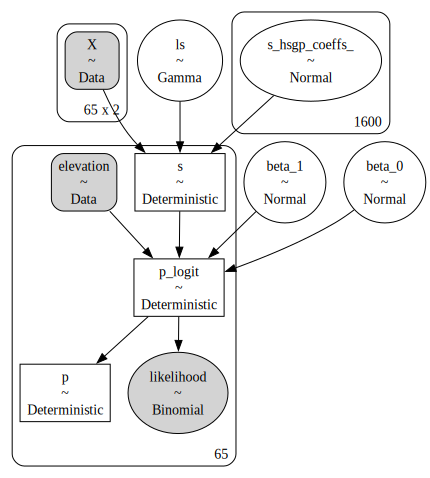

In [16]:
hsgp_model.to_graphviz()

In [17]:
with hsgp_model:
    hsgp_trace = pm.sample(
        1000, tune=2000, target_accept=0.95, nuts_sampler="numpyro", random_seed=rng
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

2024-08-28 15:12:41.392183: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce = f64[4,1000,1600,1]{3,2,1,0} reduce(f64[4,1000,1,1600,1]{4,3,2,1,0} %broadcast.9, f64[] %constant.15), dimensions={2}, to_apply=%region_1.42, metadata={op_name="jit(process_fn)/jit(main)/reduce_prod[axes=(2,)]" source_file="/var/folders/h_/9hc6pmt169bdm70pz7z4s9rm0000gn/T/tmpuppt4vln" source_line=25}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-08-28 15:13:04.025470: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 23.638298s
Constant folding an instruction is takin

 The posterior mean of the length scale is 0.21 (shown below). Therefore, we can expect the gaussian mean to decay towards 0 (since we set a 0 mean function) as we move 0.21 degrees away from any sampled point on the map. While this is not a hard cut-off due to the lengthscale not being constrained by the observed data it is still useful to be able to intuit how the lengthscale effects the estimation.

In [18]:
az.summary(hsgp_trace, var_names=["ls"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
ls,0.205,0.166,0.113,0.285


# Posterior Predictive Checks

We need to validate that our model specification properly represents the observed data. We can push out posterior predictions of the prevalence and plot them on a coordinate system to check if they resemble the observed prevalence from our sample

In [19]:
with hsgp_model:
    ppc = pm.sample_posterior_predictive(hsgp_trace, random_seed=rng)

Sampling: [likelihood]


Output()

In [20]:
posterior_prevalence = hsgp_trace["posterior"]["p"]

we can see that our posterior predictions in the figure below on the left agree with the observed sample shown on the right.

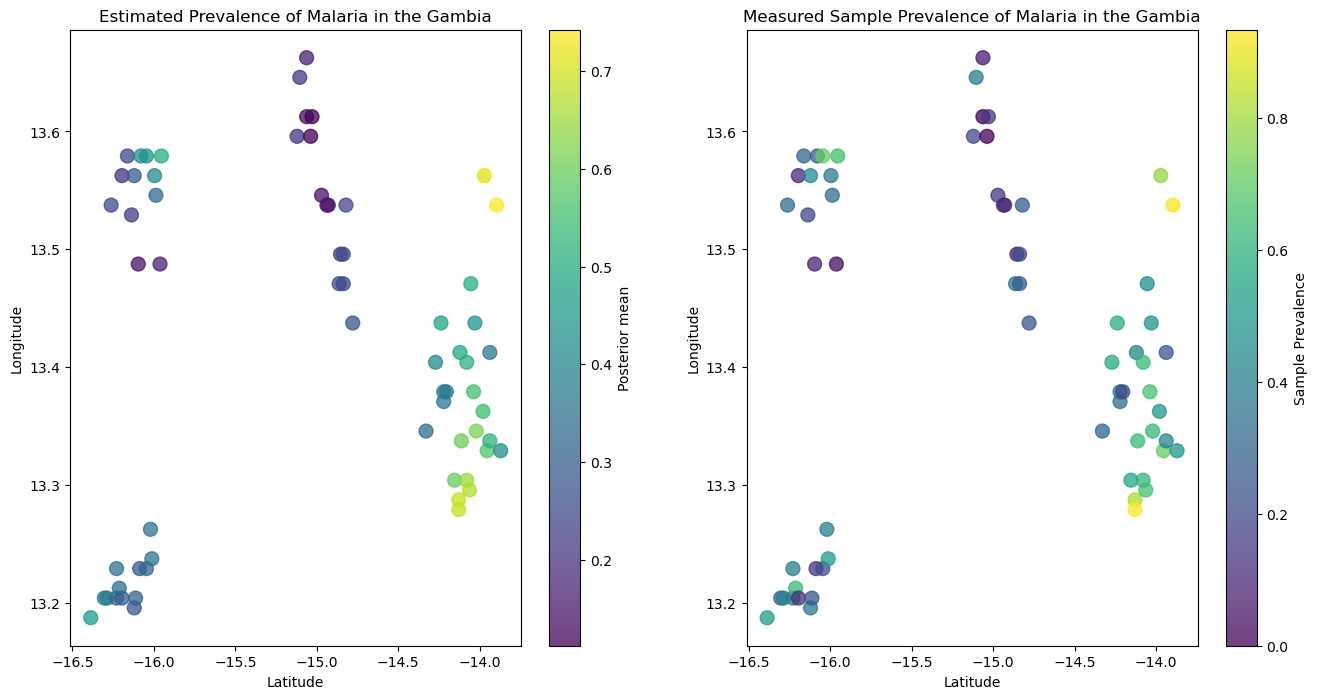

In [21]:
plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
plt.subplot(1, 2, 1)

plt.scatter(
    lonlat[:, 1],
    lonlat[:, 0],
    c=posterior_prevalence.mean(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Estimated Prevalence of Malaria in the Gambia")
plt.colorbar(label="Posterior mean")

plt.subplot(1, 2, 2)

plt.scatter(
    lonlat[:, 1],
    lonlat[:, 0],
    c=gambia_gpdf_4326["prev"],
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Measured Sample Prevalence of Malaria in the Gambia")
plt.colorbar(label="Sample Prevalence");

We can also check if the likelihood (number of individuals who test positive for malaria) agrees with the observed data. As you can see in the below figure, our posterior predictive sample is representative of the observed sample.

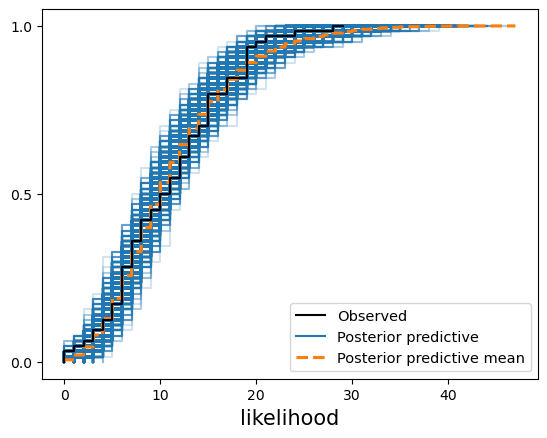

In [22]:
az.plot_ppc(ppc, kind="cumulative");

# Out-of-sample posterior predictions

Now that we have validated that we have a representative model that converged, we want to estimate the prevalence of malaria in the surrounding areas to where we have observed data points. Our new dataset will include every longitude and latitude position within the Gambia where we have a measure of elevation.

In [23]:
# Set new values for out-of-sample predictions
new_lonlat = elevations[["y", "x"]].to_numpy()
new_elev = elevations["elev"].to_numpy()
new_elev_std = (new_elev - np.mean(new_elev)) / np.std(new_elev)

In [24]:
with hsgp_model:
    pm.set_data(new_data={"X": new_lonlat, "elevation": new_elev_std})
    pp = pm.sample_posterior_predictive(hsgp_trace, var_names=["p"], random_seed=rng)

Sampling: []


Output()

In [25]:
posterior_predictive_prevalence = pp["posterior_predictive"]["p"]

We can plot our out-of-sample posterior predictions to visualize the estimated prevalence of malaria across the Gambia. In figure below you'll notice that there is a smooth transition of prevalences surrounding the areas where we observed data in a way where nearer areas have more similar prevalences and as you move away you approach zero (the mean of the guassian process).

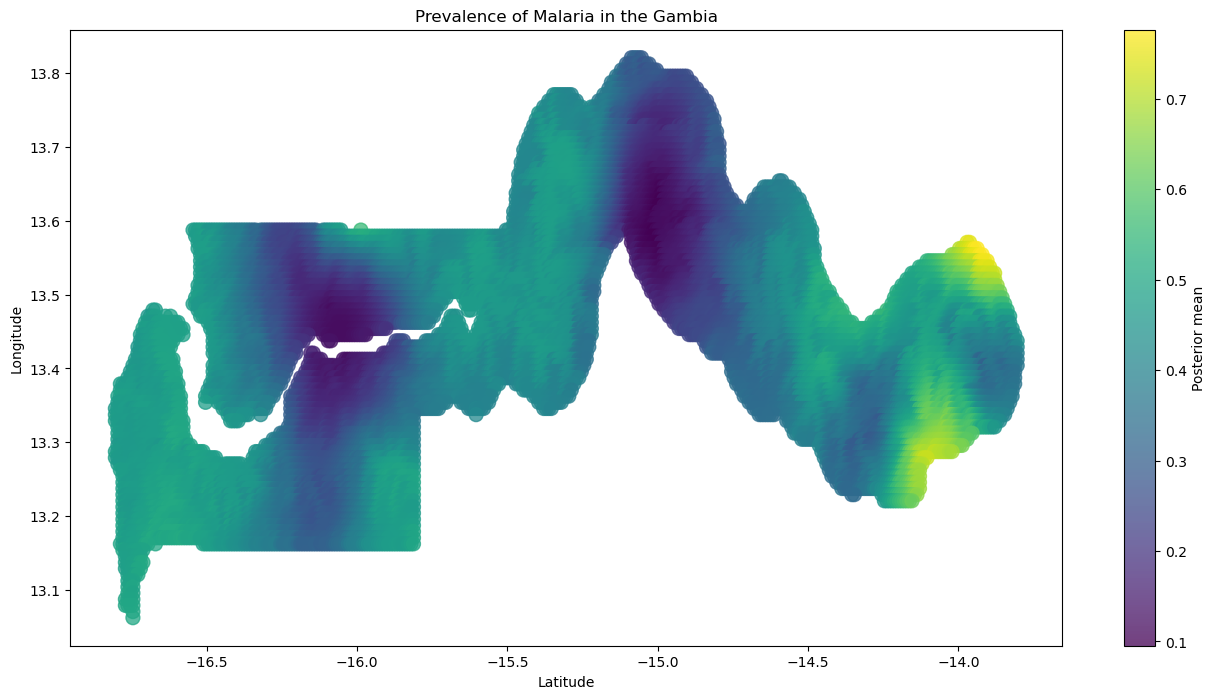

In [26]:
fig = plt.figure(figsize=(16, 8))

plt.scatter(
    new_lonlat[:, 1],
    new_lonlat[:, 0],
    c=posterior_predictive_prevalence.mean(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Prevalence of Malaria in the Gambia")
plt.colorbar(label="Posterior mean");

# Making decisions based on exceedance probabilities

One way to determine where we might decide to apply interventions is to look at exceedance probabilities of some selected threshold of malaria prevalence. These exeedance probabilities will allow us to incorporate our uncertainty in the prevalences we have estimated instead of just considering the mean of the posterior distribution. For our use case, we decide to set an exceedance threshold of 20% on the prevalance.

In [27]:
prob_prev_gt_20percent = 1 - (posterior_predictive_prevalence <= 0.2).mean(("chain", "draw"))

We can use the insights gained from the figure below to send out aid to the regions where we are most confident that the prevalence of malaria exceeds 20%.

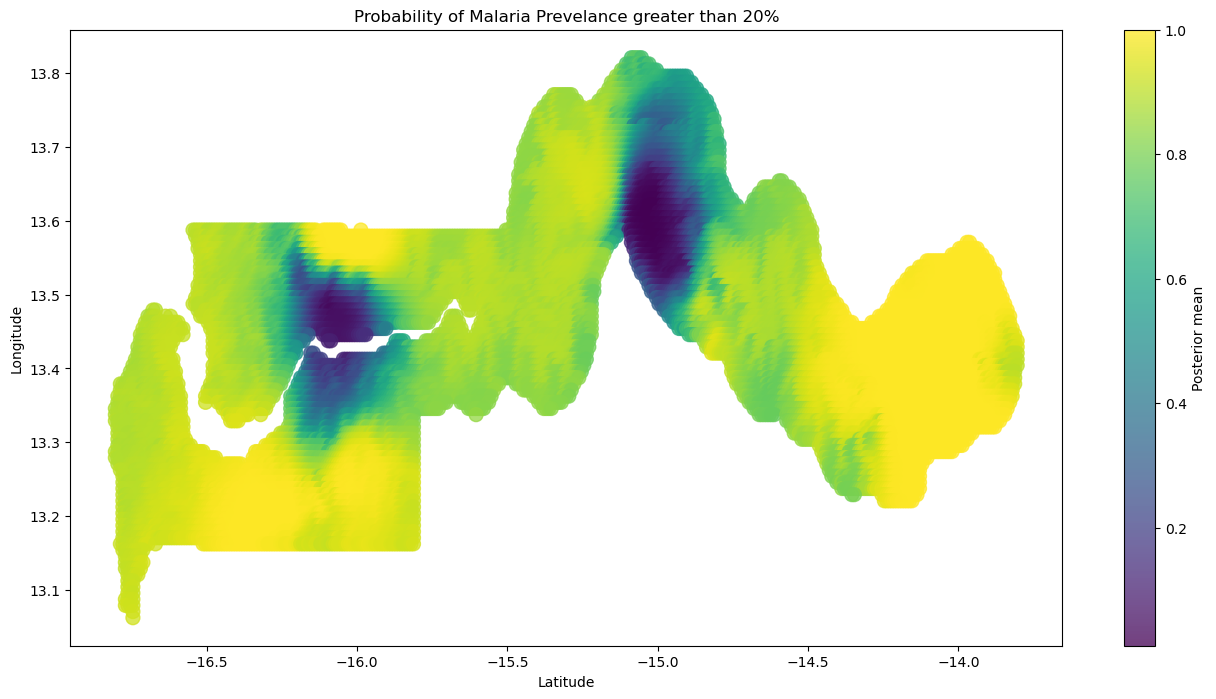

In [28]:
fig = plt.figure(figsize=(16, 8))

plt.scatter(
    new_lonlat[:, 1],
    new_lonlat[:, 0],
    c=prob_prev_gt_20percent,
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Probability of Malaria Prevelance greater than 20%")
plt.colorbar(label="Posterior mean");

# Different Covariance Functions
Before we conclude let's talk breifly about why we decided to use the Matérn family of covariance functions instead of the Exponential Quadratic. The Matérn family of covariances is a generalization of the Exponential Quadratic. When the smoothing parameter of the Matérn $\nu \to \infty$ then we have the Exponential Quadratic covariance function. As the smoothing parameter increases the function you are estimating becomes smoother. A few commonly used values for $\nu$ are $\frac{1}{2}$, $\frac{3}{2}$, and $\frac{5}{2}$. Typically, when estimating a measure that has a spatial dependence we don't want an overly smooth function because that will prevent our estimate to capture abrupt changes in the measurement we are estimating. Below we simulate some data to show how the Matérn is able to capture these abrupt changes, whereas the Exponential Quadratic is overly smooth. For simplicity's sake we will be working in one dimension but these concepts apply with two-dimensional data.

In [29]:
# simulate 1-dimensional data
x = np.linspace(0, 10, 30)
y = list()
for v in x:
    # introduce abrupt changes
    if v > 3 and v < 7:
        y.append(np.array(10.0))
    else:
        y.append(np.array(3.0))
y = np.array(y).ravel()

In [30]:
# Fit a GP to model the simulated data
with pm.Model() as matern_model:

    eta = pm.Exponential("eta", scale=10.0)
    ls = pm.Lognormal("ls", mu=0.5, sigma=0.75)
    cov_func = eta**2 * pm.gp.cov.Matern32(input_dim=1, ls=ls)
    gp = pm.gp.Latent(cov_func=cov_func)
    s = gp.prior("s", X=x[:, None])

    measurement_error = pm.Exponential("measurement_error", scale=5.0)
    pm.Normal("likelihood", mu=s, sigma=measurement_error, observed=y)
    matern_idata = pm.sample(
        draws=2000, tune=2000, nuts_sampler="numpyro", target_accept=0.98, random_seed=rng
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [31]:
with matern_model:
    ppc = pm.sample_posterior_predictive(matern_idata, random_seed=rng)

Sampling: [likelihood]


Output()

In [32]:
y_mean_ppc = ppc["posterior_predictive"]["likelihood"].mean(("chain", "draw"))

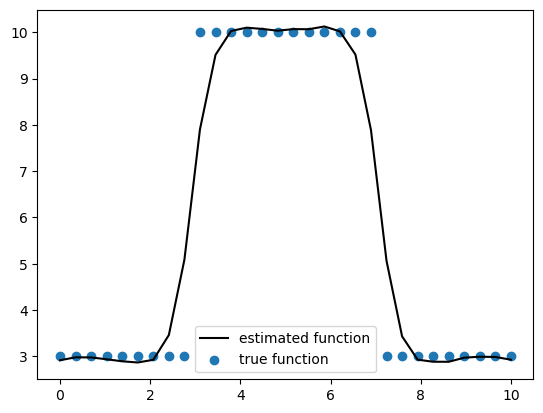

In [33]:
# Plot the estimated function against the true function
plt.plot(x, y_mean_ppc, c="k", label="estimated function")
plt.scatter(x, y, label="true function")
plt.legend(loc="best")

In [34]:
# Fit a GP to model the simulated data
with pm.Model() as expquad_model:

    eta = pm.Exponential("eta", scale=10.0)
    ls = pm.Lognormal("ls", mu=0.5, sigma=0.75)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls)
    gp = pm.gp.Latent(cov_func=cov_func)
    s = gp.prior("s", X=x[:, None])

    measurement_error = pm.Exponential("measurement_error", scale=5.0)
    pm.Normal("likelihood", mu=s, sigma=measurement_error, observed=y)
    expquad_idata = pm.sample(
        draws=2000, tune=2000, nuts_sampler="numpyro", target_accept=0.98, random_seed=rng
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [35]:
with expquad_model:
    ppc = pm.sample_posterior_predictive(expquad_idata, random_seed=rng)

Sampling: [likelihood]


Output()

In [36]:
y_mean_ppc = ppc["posterior_predictive"]["likelihood"].mean(("chain", "draw"))

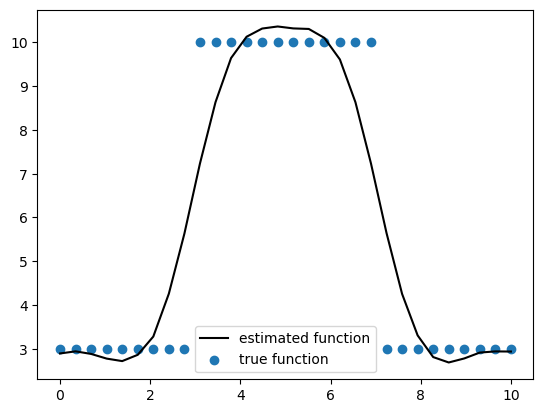

In [37]:
# Plot the estimated function against the true function
plt.plot(x, y_mean_ppc, c="k", label="estimated function")
plt.scatter(x, y, label="true function")
plt.legend(loc="best")

As you can see from the above figures. The Exponential Quadratic covariance function is too slow to capture the abrupt change but also overshoots the change due to being overly smooth. 

# Conclusion

The case-study walked us through how we can utilize an HSGP to include spatial information into our estimates. Specifically, we saw how we can validate our model specification, produce out-of-sample estimates, and how we can use the whole posterior distribution to make decisions.

## Authors

* Adapted from {ref}`Geospatial Health Data: Modeling and Visualization with R-INLA and Shiny` by Dr. Paula Moraga ([link](https://www.paulamoraga.com/book-geospatial/index.html)).
### Acknowledgments
* Bill Engels who encouraged, reviewed, and provided both feedback and code improvements to this example
* Osvaldo A Martin, reviewed and provided valuable feedback that improved the example

# References 

:::{bibliography}
:filter: docname in docnames 
:::

# Watermark

In [38]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Wed Aug 28 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

xarray: 2024.7.0

arviz      : 0.19.0
pandas     : 2.2.2
folium     : 0.17.0
mapclassify: 2.8.0
numpy      : 1.26.4
pymc       : 5.16.2
matplotlib : 3.9.1
rasterio   : 1.3.10
pytensor   : 2.25.2
geopandas  : 1.0.1

Watermark: 2.4.3



:::{include} ../page_footer.md
:::